In [1]:
import sys
from pathlib import Path
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scipy
import winner
import plot_help


##import 
sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath("")),"Code","Travis"))
print(sys.path)
import utils
import plotting
import responses_analysis
import importlib
import dfof
import numpy as np
from response2p.bestFrequency import bestFrequency as bf
from response2p.characteristicFrequency import characteristicFrequency as cf
from response2p.respondsToFreqs import respondsToFreqs as rFreqs
from response2p.responseStats import getResponses, responseStats
import config

save_path = config.save_path
data_path = config.data_path
if not save_path.exists():
    save_path.mkdir()

['c:\\Users\\travisb\\Dropbox (Personal)\\Cdh23\\Code\\Travis', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p\\python39.zip', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p\\DLLs', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p\\lib', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p', '', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p\\lib\\site-packages', 'c:\\users\\travisb\\documents\\repos\\suite2p', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p\\lib\\site-packages\\win32', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p\\lib\\site-packages\\win32\\lib', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p\\lib\\site-packages\\Pythonwin', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p\\lib\\site-packages\\setuptools\\_vendor']


In [2]:
sig_responding_neurons = []
total_neurons = []
meancorrs = []
noisecorrs = []
force = False

test = utils.findUnanalyzedStacks(data_path, pattern="**/2P/L23/[0-9]*", foldername="all")
twop_mice = responses_analysis.get2Pmice(data_path, test)
responseProperties = pd.DataFrame()

for index, row in twop_mice.iterrows():
    print(row['Mouse'])
    analysis_dir = row['2P_path'] / "response_analysis"
    if not analysis_dir.exists():
        (row['2P_path'] / "response_analysis").mkdir()

    if (analysis_dir / "unmixed.npy").exists():
        unmixed = np.load(analysis_dir / "unmixed.npy")
    else:
        temp = dfof.processFluor(dir = row['2P_path'])
        temp.loadTraces()
        temp.calc_dfof(window=500, step = 50, percentile=10, cutoff = 20)
        temp.unmix(numBaseline=15, framesAfter=60)
        np.save(analysis_dir / "unmixed.npy", temp.unmixed)

    responsive_file = analysis_dir / "isResponsive.csv"
    if responsive_file.exists() and not force:
        isResponsive = pd.read_csv(responsive_file)
    else:
        isResponsive = responses_analysis.isResponsive(unmixed, alpha = 0.01)
        isResponsive.to_csv(responsive_file, index=False)


    ####now which responses are sound responsive?
    response_stats_file = analysis_dir / "responseStats.csv"
    if response_stats_file.exists() and not force:
        df_stats = pd.read_csv(response_stats_file)
    else:
        df = getResponses(unmixed)
        df_stats = responseStats(df, isResponsive)
        df_stats.to_csv(response_stats_file, index=False)

    bfreqs = bf(df_stats)
    cfreqs = cf(df_stats)
    #bws = bandwidth(df_stats, attenLevel=2, mustBeContinuous=True)
    freqResponders = rFreqs(df_stats, rejectAtten=[0,2,3])

    temp = bfreqs.merge(cfreqs, on='neuron')
    #temp = temp.merge(bws, on='neuron')
    temp = temp.merge(freqResponders, on='neuron')
    temp['Mouse'] = row['Mouse']

    ##add suite2p data
    s2p = row['2P_path']
    isCell = np.load(s2p / "suite2p/plane0/iscell.npy", allow_pickle=True)
    stat = np.load(s2p / "suite2p/plane0/stat.npy", allow_pickle=True)
    stat = stat[isCell[:,0] == 1]
    temp2 = pd.DataFrame({"neuron": np.arange(0,len(stat)), "xpix":[st['xpix'] for st in stat],
    "ypix":[st['ypix'] for st in stat], 'med': [st['med'] for st in stat]
    })

    temp = pd.merge(temp, temp2,on="neuron")
    
    responseProperties = pd.concat((responseProperties, temp))
    

**/2P/L23/[0-9]* all
m602
m603
m609
m670
m674
m675
m659
m722
m664
m666
m900
m984
m985
m1315
m1321
m1318
m1323
m1493
m1937
m2065
m1983


In [3]:
colors_ito = {'black':[0,0,0], 'orange':[230,159,0], 'skyblue':[86,180,233], 'green':[0,158,115],
        'yellow':[240,228,66], 'blue':[0,114,178], 'darkorange':[213,94,0], 'purple': [204,121,167]}
colors_ito = {key: (np.array(colors_ito[key])/255).tolist() for key in colors_ito.keys()}
colors = {-1:[1,1,1], 0:colors_ito['blue'],1:colors_ito['skyblue'],2:colors_ito['green'], 3:colors_ito['yellow'], 4:colors_ito["darkorange"]}
colors_list = [colors[ex] for ex in colors.keys()]

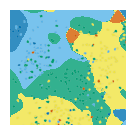

In [29]:
#### plot for example
importlib.reload(plot_help)
ex_mouse = 'm670'
plot_help.plotCharFreqMap(responseProperties, ex_mouse, alpha = 0.2, figsize = (1.5,1.5), showIntensity = False)

plt.xlim([200,800])
plt.ylim([200,800])
plt.savefig(save_path / "Fig4_AB_example_neurons.svg", dpi=600)

winnerImage = winner.winner_take_all(data = responseProperties[responseProperties['Mouse']==ex_mouse], radius = 30)
winnerimage = winnerImage['winner_image'].values[0]
plt.imshow(winnerimage.T, cmap = ListedColormap(colors_list), alpha=0.8)

plt.savefig(save_path / "Fig4_B_winner_take_all.svg", dpi=600)

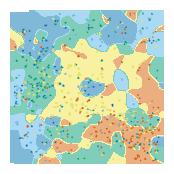

In [30]:
### Ahl+ B6 example
del winner
import winner
import plot_help
fig, ax = plot_help.plotCharFreqMap(responseProperties, mouse = 'm675', alpha=0.25, figsize=(2,2))

winner_i = winner.winner_take_all(data = responseProperties[responseProperties['Mouse']=='m675'], radius = 30)
winnerimage = winner_i['winner_image'].values[0]
plt.imshow(winnerimage.T, cmap = ListedColormap(colors_list), alpha=0.5, vmin=-1, vmax = 5)

plt.savefig(save_path / "Fig4_C_Ahl+_example.svg", dpi=600)

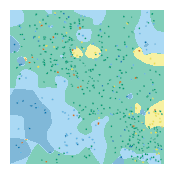

In [31]:
###B6 example
fig, ax = plot_help.plotCharFreqMap(responseProperties, mouse = 'm2065', alpha=0.25, figsize=(2,2))

winnerImage = winner.winner_take_all(data = responseProperties[responseProperties['Mouse']=='m2065'], radius = 30)
winnerimage = winnerImage['winner_image'].values[0]
plt.imshow(winnerimage.T, cmap = ListedColormap(colors_list), alpha=0.5,vmin=-1, vmax=4)

plt.savefig(save_path / "Fig4_C_B6_example.svg", dpi=600)

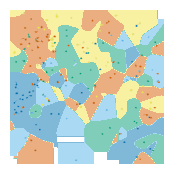

In [32]:
###Ahl+ CBA.B6 example
fig, ax = plot_help.plotCharFreqMap(responseProperties, mouse = 'm722', alpha=0.25, figsize=(2,2))

winnerImage = winner.winner_take_all(data =responseProperties[responseProperties['Mouse']=='m722'], radius = 30)
winnerimage = winnerImage['winner_image'].values[0]
plt.imshow(winnerimage.T, cmap = ListedColormap(colors_list), alpha=0.5)

plt.savefig(save_path / "SF2_C_CBA_B6_Ahl+_example.svg", dpi=600)

In [4]:
### go through every mouse and calculate winner takes all
import winner

winner_df = winner.winner_take_all(responseProperties, radius = 30)

mouse_str = []
charFreq = []
proportion = []
for i, row in winner_df.iterrows():
        mouse_str.append(row['Mouse'])
        charFreq.append(0)
        low = np.mean((row['winner_image'] >= 0) & (row['winner_image'] < 3))
        proportion.append(low)

        mouse_str.append(row['Mouse'])
        charFreq.append(3)
        high = np.mean(row['winner_image'] >= 3) 
        proportion.append(high)

winner_prop_df = pd.DataFrame({'Mouse':mouse_str, "charFreq":charFreq, "proportion":proportion})

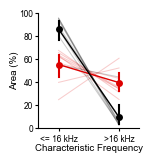

In [8]:
win = winner_prop_df.merge(twop_mice, on='Mouse')
win['prop_percent'] = win['proportion'] * 100

color_dict = config.color_dict
order = ['Thy1-GC6s; Cdh23 (ahl/ahl)','Thy1-GC6s; Cdh23 (Ahl/ahl)']
fig, ax = plt.subplots(figsize=(1.3,1.5))
sns.lineplot(win[win['Genotype']!='(F1) Thy1-GC6s; Cdh23 (Ahl/ahl)'], x='charFreq', y='prop_percent', hue='Genotype', size=0, palette=color_dict, alpha = 0.2, units='Mouse', estimator=None)
sns.lineplot(win[win['Genotype']!='(F1) Thy1-GC6s; Cdh23 (Ahl/ahl)'], x='charFreq', y='prop_percent', hue='Genotype', marker=".", markersize=10, linewidth = 1, markeredgewidth=0, palette=color_dict, err_style="bars")
ax.get_legend().remove()
plt.ylabel("Area (%)", fontsize=7, labelpad = 0)
plt.xlim([-1,4])
plt.ylim([0,100])
plt.xticks(ticks=[0,3], labels = ['<= 16 kHz', '>16 kHz'])
plt.xlabel("Characteristic Frequency", fontsize=7, labelpad = 0)
plotting.figQuality(fig, ax)
plt.savefig(save_path/ "Fig4_D_area_graph.svg")

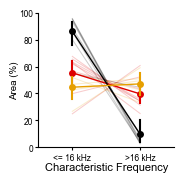

In [12]:
### 3 genos
color_dict = config.color_dict
order = config.order
fig, ax = plt.subplots(figsize=(1.75,1.75))
sns.lineplot(win, x='charFreq', y='prop_percent', hue='Genotype', size=0, palette=color_dict, alpha = 0.2, units='Mouse', estimator=None)
sns.lineplot(win, x='charFreq', y='prop_percent', hue='Genotype', marker=".", markersize=10, linewidth = 1, markeredgewidth=0, palette=color_dict, err_style="bars")
ax.get_legend().remove()
plt.ylabel("Area (%)", fontsize=7, labelpad = 0)
plt.xlim([-1.5,4.5])
plt.xticks(ticks=[0,3], labels = ['<= 16 kHz', '>16 kHz'])
plt.ylim([0,100])
plt.xlabel("Characteristic Frequency", fontsize=8, labelpad = 0)
plotting.figQuality(fig, ax)
#plt.legend("")
plt.savefig(save_path/ "SF2_D_area_graph_3genos.svg")

In [36]:
model = ols('proportion ~ C(charFreq) + + C(Genotype) + C(Genotype):C(charFreq)', data=win).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(charFreq),1.246017,1.0,72.983404,3.494019e-10
C(Genotype),0.002593,2.0,0.075928,9.270308e-01
C(Genotype):C(charFreq),1.182828,2.0,34.641106,4.083711e-09
Residual,0.614614,36.0,NaN,NaN


In [37]:
import scipy
from statsmodels.stats.multitest import multipletests
import itertools
def ttests_within(data, iv_cat, dv_cat):
    #iv_2: independent variable, frequency
    #dv_cat: dependent variable, proportions
    genotypes = data['Genotype'].unique()
    combos = itertools.combinations(genotypes,2)
    ivs = data[iv_cat].unique()

    pvalues = []
    geno1s = [] 
    geno2s = []
    iv_list = []
    mean1, std1, mean2, std2 = ([],[],[],[])
    
    for combo in combos:
        print(combo)
        print(ivs)
        for iv in ivs:
            temp1 = data[(data['Genotype']==combo[0]) & (data[iv_cat]==iv)]
            temp2 = data[(data['Genotype']==combo[1]) & (data[iv_cat]==iv)]
            pvalues.append(scipy.stats.ttest_ind(temp1[dv_cat], temp2[dv_cat]).pvalue)
            geno1s.append(combo[0])
            geno2s.append(combo[1])
            iv_list.append(iv)
            mean1.append(temp1[dv_cat].mean())
            mean2.append(temp2[dv_cat].mean())
            std1.append(temp1[dv_cat].std())
            std2.append(temp2[dv_cat].std())

    for geno in genotypes:
        temp1 = data[(data['Genotype']==geno) & (data[iv_cat]==0)]
        temp2 = data[(data['Genotype']==geno) & (data[iv_cat]==3)]
        geno1s.append(geno)
        geno2s.append(geno)
        iv_list.append(5)
        mean1.append(temp1[dv_cat].mean())
        mean2.append(temp2[dv_cat].mean())
        std1.append(temp1[dv_cat].std())
        std2.append(temp2[dv_cat].std())
        pvalues.append(scipy.stats.ttest_ind(temp1[dv_cat], temp2[dv_cat]).pvalue)

    stats_df = pd.DataFrame({"geno1":geno1s, "geno2": geno2s, iv_cat:iv_list, "mean1":mean1, "std1":std1,"mean2":mean2,"std2":std2,"pval":pvalues})
    mt = multipletests(stats_df['pval'], alpha = 0.05, method="fdr_bh")
    stats_df['reject_hs'] = mt[0]
    stats_df['pval_corrected'] = mt[1]
    return stats_df

bf_stats = ttests_within(win,'charFreq','proportion')
bf_stats


('Thy1-GC6s; Cdh23 (Ahl/ahl)', 'Thy1-GC6s; Cdh23 (ahl/ahl)')
[0 3]
('Thy1-GC6s; Cdh23 (Ahl/ahl)', '(F1) Thy1-GC6s; Cdh23 (Ahl/ahl)')
[0 3]
('Thy1-GC6s; Cdh23 (ahl/ahl)', '(F1) Thy1-GC6s; Cdh23 (Ahl/ahl)')
[0 3]


,geno1,geno2,charFreq,mean1,std1,mean2,std2,pval,reject_hs,pval_corrected
0,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),0,0.553368,0.150424,0.860528,0.136814,7.734323e-04,True,1.392178e-03
1,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),3,0.396917,0.117844,0.097403,0.142160,4.221511e-04,True,9.498399e-04
2,Thy1-GC6s; Cdh23 (Ahl/ahl),(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),0,0.553368,0.150424,0.446781,0.110643,2.005168e-01,False,2.578073e-01
3,Thy1-GC6s; Cdh23 (Ahl/ahl),(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),3,0.396917,0.117844,0.471275,0.096891,2.634925e-01,False,2.964291e-01
4,Thy1-GC6s; Cdh23 (ahl/ahl),(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),0,0.860528,0.136814,0.446781,0.110643,1.436919e-04,True,6.466135e-04
5,Thy1-GC6s; Cdh23 (ahl/ahl),(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),3,0.097403,0.142160,0.471275,0.096891,3.228466e-04,True,9.498399e-04
6,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (Ahl/ahl),5,0.553368,0.150424,0.396917,0.117844,3.625102e-02,False,5.437652e-02
7,Thy1-GC6s; Cdh23 (ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),5,0.860528,0.136814,0.097403,0.142160,3.036984e-08,True,2.733286e-07
8,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),5,0.446781,0.110643,0.471275,0.096891,7.192642e-01,False,7.192642e-01


In [38]:
# for mouse in responseProperties['Mouse'].unique():
#     ex = responseProperties[responseProperties['Mouse']==mouse]
#     colors = {0:[0,0,1],1:[0,1,1],2:[0,1,0],3:[1,1,0],4:[1,0,0]}
#     test = np.zeros((1024,1024,4))
#     #test[:,:,3]=1

#     for cf in ex.sort_values(by='charFreq')['charFreq'].unique():
#         temp = ex[(ex['charFreq']==cf)]
#         for i, cell in temp.iterrows():
#             signal = np.zeros((1024,1024))
#             signal[cell['ypix'],cell['xpix']] = 1
#             test[:,:,0] = test[:,:,0] + signal * colors[cf][0]
#             test[:,:,1] = test[:,:,1] + signal * colors[cf][1]
#             test[:,:,2] = test[:,:,2] + signal * colors[cf][2]
#             test[:,:,3] = test[:,:,3] + signal * 1

#     plt.imshow(test)
#     plt.title(str(mouse) + " " + twop_mice[twop_mice['Mouse']==mouse]['Genotype'].values[0])
#     plt.show()